In [12]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from cv2 import imread
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Normalize, Compose
from pathlib import Path

In [14]:
normalize = Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
data_transforms = {
    'train':
    Compose([
        transforms.Resize((244, 244)),
        transforms.RandomAffine(90, shear=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    Compose([
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        normalize
    ])
}
image_datasets = {
    'train':
        ImageFolder('/content/drive/MyDrive/SMART AI/train_data', data_transforms['train']),
    'validation':
        ImageFolder('/content/drive/MyDrive/SMART AI/test_data', data_transforms['validation'])
}
dataloaders = {
    'train':
        DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0),
    'validation':
        DataLoader(image_datasets['validation'], batch_size=32, shuffle=True, num_workers=0)
}

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = resnet50(pretrained=False).to(device)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 16)
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
def train_model(model, optimizer, criterion, epochs):

    for epoch in range(epochs):
        print('Epoch: ' + str(epoch+1) + '/' + str(epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss, running_corrects = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(phase + ' loss/acc: ' + str(epoch_loss) + '/' + str(epoch_acc))

    return model
trained_model = train_model(model, optimizer, criterion, 3)

Epoch: 1/3
----------
train loss/acc: 0.7968035782749454/tensor(0.7867, dtype=torch.float64)
validation loss/acc: 0.6328108708063761/tensor(1., dtype=torch.float64)
Epoch: 2/3
----------
train loss/acc: 0.0001445336286451493/tensor(1., dtype=torch.float64)
validation loss/acc: 0.016688636384713344/tensor(1., dtype=torch.float64)
Epoch: 3/3
----------
train loss/acc: 8.821468568243062e-07/tensor(1., dtype=torch.float64)
validation loss/acc: 0.00038743907666335313/tensor(1., dtype=torch.float64)


In [17]:
torch.save(trained_model.state_dict(), 'weights.h5')
model = resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 16).to(device)
)
model.load_state_dict(torch.load('weights.h5'))

<All keys matched successfully>

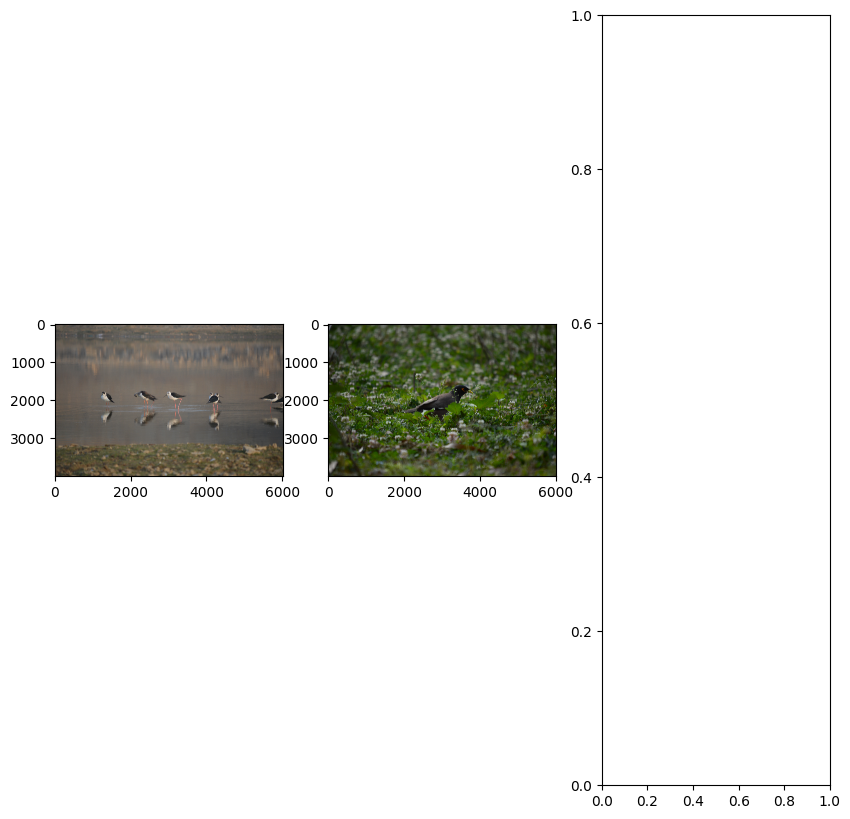

In [23]:
img_data = '/content/drive/MyDrive/SMART AI/test_data/test_data/'
validation_img_paths = ['blasti/DSC_6396.jpg', 'cmnmyn/DSC_2443.jpg']
img_list = [Image.open(img_data+img_path) for img_path in validation_img_paths]

validation_batch = torch.stack([data_transforms['validation'](img).to(device) for img in img_list])
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
ax1.imshow(img_list[0])
ax2.imshow(img_list[1])
plt.show()

In [21]:
print('Predicted Probabilities')
for i, img in enumerate(img_list):
    print('Image ' + str(i) + ': ' + str(100*pred_probs[i, 0]) + '%')

Predicted Probabilities
Image 0: 100.0%
Image 1: 100.0%
